## DQN (Q2)


In [1]:
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym pyvirtualdisplay torch

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [858 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [55.6 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://security.ubuntu.com/ubuntu 

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
import base64
import glob
import io
from gym.wrappers.monitoring.video_recorder import VideoRecorder

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_size, 512)
        self.fc2 = torch.nn.ReLU()
        self.fc3 = torch.nn.LayerNorm(512)
        self.fc4 = torch.nn.Dropout(0.1)
        self.fc5 = torch.nn.Linear(512, 512)
        self.fc6 = torch.nn.ReLU()
        self.fc7 = torch.nn.LayerNorm(512)
        self.fc8 = torch.nn.Dropout(0.1)
        self.fc9 = torch.nn.Linear(512, 512)
        self.fc10 = torch.nn.ReLU()
        self.fc11 = torch.nn.Linear(512, action_size)

    def forward(self, x):
        return self.fc11(self.fc10(self.fc9(self.fc8(self.fc7(self.fc6(self.fc5(self.fc4(self.fc3(self.fc2(self.fc1(x)))))))))))

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        e = (state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

class DQNAgent:
    def __init__(self, state_size, action_size, seed, buffer_size, batch_size, gamma, lr, tau, update_every):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        self.batch_size = batch_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        self.memory = ReplayBuffer(buffer_size, batch_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
!pip install swig
!apt-get install -y swig
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 53 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (480 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selectin

In [14]:
def train(agent, env, n_episodes=250, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done , info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window)>=200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

env = gym.make('LunarLander-v2')
agent1 = DQNAgent(state_size=8, action_size=4, seed=0, buffer_size=int(1e5), batch_size=128, gamma=0.99, lr=5e-4, tau=1e-3, update_every=4)
scores1 = train(agent1, env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 50	Average Score: -171.86
Episode 100	Average Score: -153.24
Episode 150	Average Score: -114.45
Episode 200	Average Score: -86.08
Episode 250	Average Score: -43.08


In [15]:
env = gym.make('LunarLander-v2')
agent11 = DQNAgent(state_size=8, action_size=4, seed=0, buffer_size=int(1e5), batch_size=128, gamma=0.99, lr=1e-2, tau=1e-3, update_every=4)
scores11 = train(agent11, env)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 50	Average Score: -133.56
Episode 100	Average Score: -99.91
Episode 150	Average Score: -47.17
Episode 200	Average Score: -4.22
Episode 250	Average Score: 29.80


In [18]:
env = gym.make('LunarLander-v2')
agent2 = DQNAgent(state_size=8, action_size=4, seed=0, buffer_size=int(1e5), batch_size=64, gamma=0.99, lr=1e-4, tau=1e-3, update_every=4)
scores2 = train(agent2, env)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 50	Average Score: -160.16
Episode 100	Average Score: -143.85
Episode 150	Average Score: -106.32
Episode 200	Average Score: -85.13
Episode 250	Average Score: -70.79


In [19]:
env = gym.make('LunarLander-v2')
agent3 = DQNAgent(state_size=8, action_size=4, seed=0, buffer_size=int(1e5), batch_size=32, gamma=0.99, lr=1e-4, tau=1e-3, update_every=4)
scores3 = train(agent3, env)

Episode 50	Average Score: -165.70
Episode 100	Average Score: -160.54
Episode 150	Average Score: -128.28
Episode 200	Average Score: -89.41
Episode 250	Average Score: -68.25


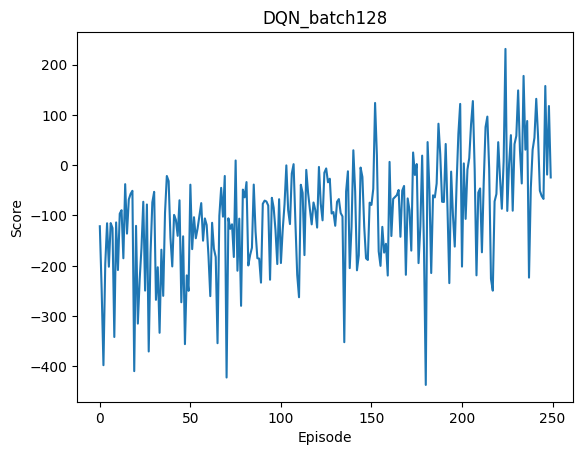

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores1)), scores1)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title(f"DQN_batch128")
plt.savefig(f"DQN_batch128.pdf")
plt.show()

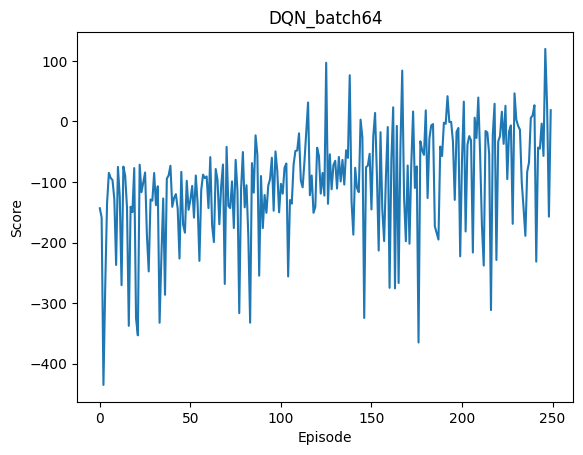

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores2)), scores2)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title(f"DQN_batch64")
plt.savefig(f"DQN_batch64.pdf")
plt.show()

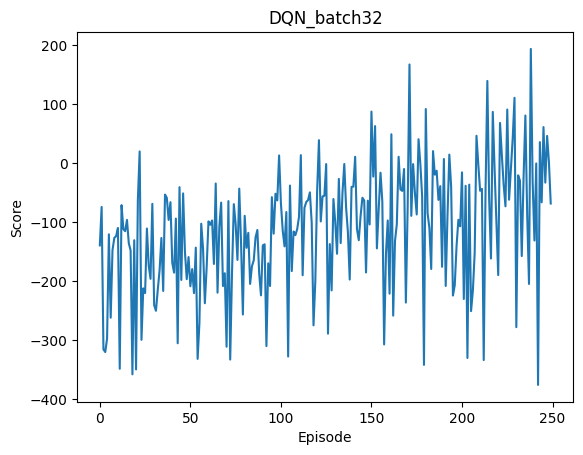

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores3)), scores3)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title(f"DQN_batch32")
plt.savefig(f"DQN_batch32.pdf")
plt.show()

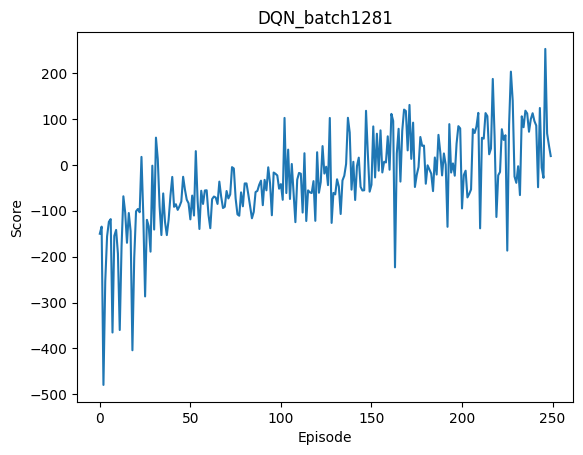

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores11)), scores11)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title(f"DQN_batch1281")
plt.savefig(f"DQN_batch1281.pdf")
plt.show()

## Videos for DQN

In [4]:
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym torch pyvirtualdisplay

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [5]:
!sudo apt-get install xvfb
!pip install xvfbwrapper

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 53 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [6]:
import base64
import glob
import io
import gym
import torch
from IPython.display import HTML, display
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import os

In [7]:
if not os.path.exists('video'):
    os.makedirs('video')
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipy_display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
def show_video_of_model(agent, env_name):
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

    env = gym.make(env_name)
    vid = VideoRecorder(env, path="video/{}.mp4".format(env_name))


    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        vid.capture_frame()

    vid.close()
    env.close()
    virtual_display.stop()

In [34]:
show_video_of_model(agent1, 'LunarLander-v2')
show_video('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [5]:
def train2(agent, env, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done , info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window)>=200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

## DQN with 1000 episodes

In [6]:
env = gym.make('LunarLander-v2')
agent4 = DQNAgent(state_size=8, action_size=4, seed=0, buffer_size=int(1e5), batch_size=128, gamma=0.99, lr=5e-4, tau=1e-3, update_every=4)
scores4 = train2(agent4, env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 50	Average Score: -181.55
Episode 100	Average Score: -152.64
Episode 150	Average Score: -107.98
Episode 200	Average Score: -75.44
Episode 250	Average Score: -42.41
Episode 300	Average Score: -11.21
Episode 350	Average Score: -5.00
Episode 400	Average Score: 10.46
Episode 450	Average Score: 38.44
Episode 500	Average Score: 103.23
Episode 550	Average Score: 146.37
Episode 600	Average Score: 129.45
Episode 650	Average Score: 139.17
Episode 700	Average Score: 170.32
Episode 750	Average Score: 192.26
Episode 775	Average Score: 201.79
Environment solved in 675 episodes!	Average Score: 201.79


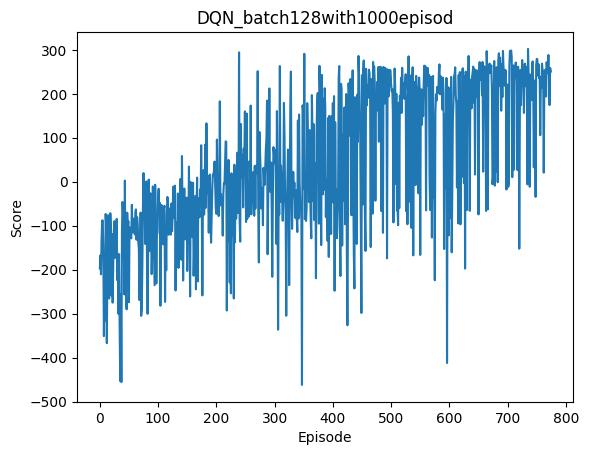

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores4)), scores4)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title(f"DQN_batch128with1000episod")
plt.savefig(f"DQN_batch128with1000episod.pdf")
plt.show()

In [11]:
if not os.path.exists('video'):
    os.makedirs('video')
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipy_display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
def show_video_of_model(agent, env_name):
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

    env = gym.make(env_name)
    vid = VideoRecorder(env, path="video/{}.mp4".format(env_name))


    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        vid.capture_frame()

    vid.close()
    env.close()
    virtual_display.stop()

In [15]:
show_video_of_model(agent4, 'LunarLander-v2')
show_video('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [8]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
import base64
import glob
import io
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import os

In [9]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_size, 512)
        self.fc2 = torch.nn.ReLU()
        self.fc3 = torch.nn.LayerNorm(512)
        self.fc4 = torch.nn.Dropout(0.1)
        self.fc5 = torch.nn.Linear(512, 512)
        self.fc6 = torch.nn.ReLU()
        self.fc7 = torch.nn.LayerNorm(512)
        self.fc8 = torch.nn.Dropout(0.1)
        self.fc9 = torch.nn.Linear(512, 512)
        self.fc10 = torch.nn.ReLU()
        self.fc11 = torch.nn.Linear(512, action_size)

    def forward(self, x):
        return self.fc11(self.fc10(self.fc9(self.fc8(self.fc7(self.fc6(self.fc5(self.fc4(self.fc3(self.fc2(self.fc1(x)))))))))))


In [29]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size , device):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device
    def add(self, state, action, reward, next_state, done):
        e = (state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class DDQNAgent:
    def __init__(self, state_size, action_size, seed, buffer_size, batch_size, gamma, lr, tau, update_every , device):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        self.batch_size = batch_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        self.memory = ReplayBuffer(buffer_size, batch_size , device)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_local_next = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, Q_local_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)



In [25]:
def train_double(agent, env, n_episodes=250, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window)>=200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

            if not os.path.exists('checkpoints'):
                os.makedirs('checkpoints')
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env_db = gym.make('LunarLander-v2')
agent_db = DDQNAgent(state_size=8, action_size=4, seed=0, buffer_size=int(1e5), batch_size=128, gamma=0.99, lr=5e-4, tau=1e-3, update_every=4 , device = device)
scores_db = train_double(agent_db, env_db)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 50	Average Score: -176.15
Episode 100	Average Score: -161.41
Episode 150	Average Score: -127.47
Episode 200	Average Score: -91.01
Episode 250	Average Score: -59.23


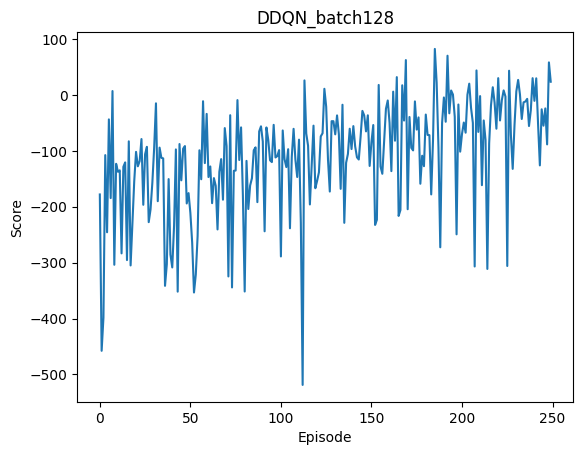

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores_db)), scores_db)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title(f"DDQN_batch128")
plt.savefig(f"DDQN_batch128.pdf")
plt.show()

In [36]:
if not os.path.exists('video_db'):
    os.makedirs('video_db')
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipy_display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
def show_video_of_model(agent, env_name):
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

    env = gym.make(env_name)
    vid = VideoRecorder(env, path="video/{}.mp4".format(env_name))


    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        vid.capture_frame()

    vid.close()
    env.close()
    virtual_display.stop()

In [37]:
show_video_of_model(agent_db, 'LunarLander-v2')
show_video('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [13]:
def train_double2(agent, env, n_episodes=800, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 50 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window)>=200.0:
            print(f'\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

            if not os.path.exists('checkpoints'):
                os.makedirs('checkpoints')
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [33]:
env_db2 = gym.make('LunarLander-v2')
agent_db2 = DDQNAgent(state_size=8, action_size=4, seed=0, buffer_size=int(1e5), batch_size=128, gamma=0.99, lr=5e-4, tau=1e-3, update_every=4 , device = device)
scores_db2 = train_double2(agent_db2, env_db2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 50	Average Score: -184.27
Episode 100	Average Score: -149.37
Episode 150	Average Score: -115.85
Episode 200	Average Score: -94.59
Episode 250	Average Score: -57.11
Episode 300	Average Score: -3.79
Episode 350	Average Score: 51.65
Episode 400	Average Score: 78.01
Episode 450	Average Score: 102.97
Episode 500	Average Score: 152.49
Episode 550	Average Score: 177.34
Episode 600	Average Score: 187.12
Episode 629	Average Score: 201.12
Environment solved in 529 episodes!	Average Score: 201.12


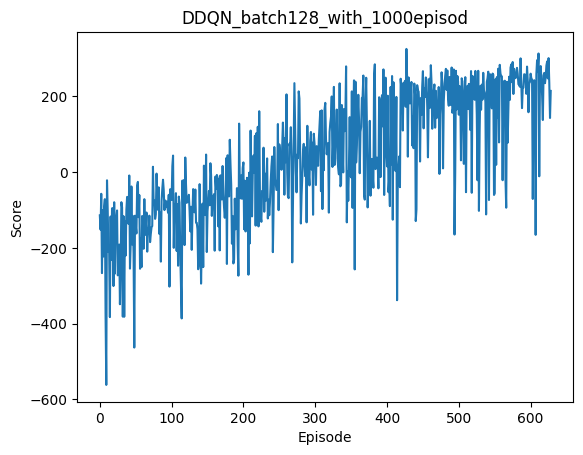

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(scores_db2)), scores_db2)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title(f"DDQN_batch128_with_1000episod")
plt.savefig(f"DDQN_batch128_with_1000episod.pdf")
plt.show()

In [35]:
show_video_of_model(agent_db2, 'LunarLander-v2')
show_video('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 